In [32]:
import core
from dataset_helpers import filter_data, group_by_attributes, apply_aggregation
from typing import List, Dict, Any, Optional
from aggregations import mean, median, count, top_n, describe_numeric
from attribute_manager import add_field
import statistics
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

In [10]:
print("Загрузка данных из АПИ...")
laureates_data = core.load_data()
print(f"Загружено {len(laureates_data)} записей")

Загрузка данных из АПИ...
Загружено 25 записей


##### Функции для анализа данных

In [14]:
def filter_by_num_prizes(data: List[Dict], min_prizes: int = 1, max_prizes: int = None) -> List[Dict]:
    """
    функция фильтрует лауреатов по количеству призов
    
    Args:
        data: список лауреатов
        min_prizes: минимальное количество призов
        max_prizes: максимальное количество призов 
    
    Returns:
        отфильтрованный список
    """
    filtered = []
    for item in data:
        num_prizes = len(item.get('prizes_relevant', []))
        if num_prizes >= min_prizes:
            if max_prizes is None or num_prizes <= max_prizes:
                filtered.append(item)
    return filtered


def output_metric_by_category(data: List[Dict], metric_func: callable, metric_name: str = "metric") -> Dict[str, Any]:
    """
    категоризация по призам
    
    Args:
        data: список лауреатов
        metric_func: функция для вычисления метрики
        metric_name: название метрики для вывода
    
    Returns:
        словарь с метриками по категориям
    """
    #группировка призов
    category_data = defaultdict(list)
    
    for item in data:
        prizes = item.get('prizes_relevant', [])
        for prize in prizes:
            category = prize.get('category_en')
            if category:
                metric_value = metric_func(item, prize)
                if metric_value is not None:
                    category_data[category].append(metric_value)
    
    #агрегация
    result = {}
    for category, values in category_data.items():
        if values:
            result[category] = {
                'count': len(values),
                'mean': statistics.mean(values),
                'median': statistics.median(values) if len(values) > 1 else values[0]
            }
    
    print(f"{metric_name} по категориям:")
    for category, stats in sorted(result.items()):
        print(f"  {category}: {stats['mean']:.1f} (n={stats['count']})")
    
    return result


def add_migration_field(data: List[Dict]) -> List[Dict]:
    """для анализа миграции"""
    def get_country_of_origin(item: Dict) -> str:
        if item.get('type_') == 'person':
            return item.get('country_birth')
        elif item.get('type_') == 'organization':
            return item.get('country_founded')
        return None
    
    for item in data:
        item['country_of_origin_adjusted'] = get_country_of_origin(item)
        item['has_migrated'] = (
            item.get('country_of_origin_adjusted') and 
            item.get('country_now') and
            item['country_of_origin_adjusted'] != item['country_now']
        )
    
    return data

# 1.Анализ по странам

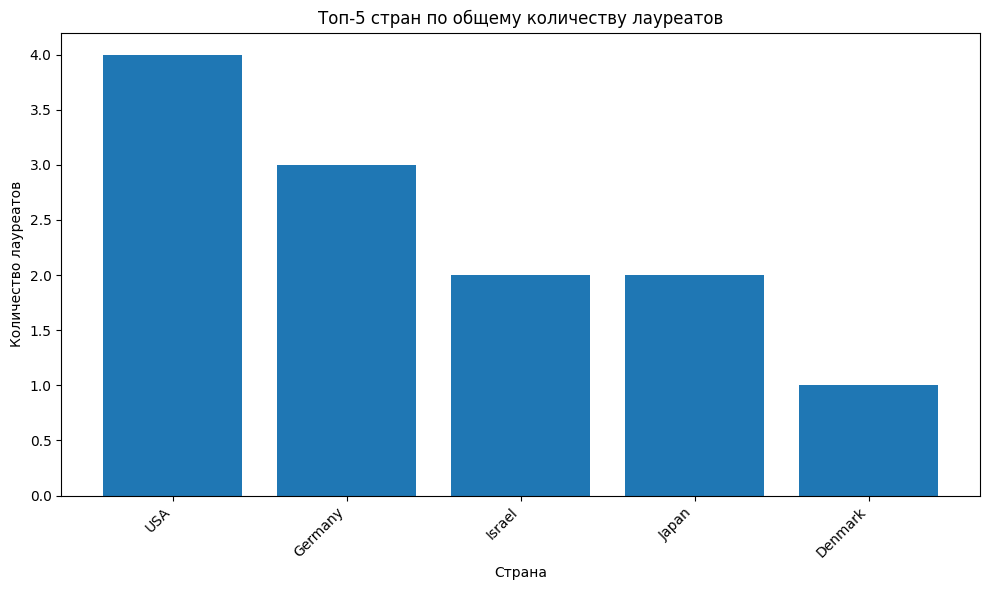

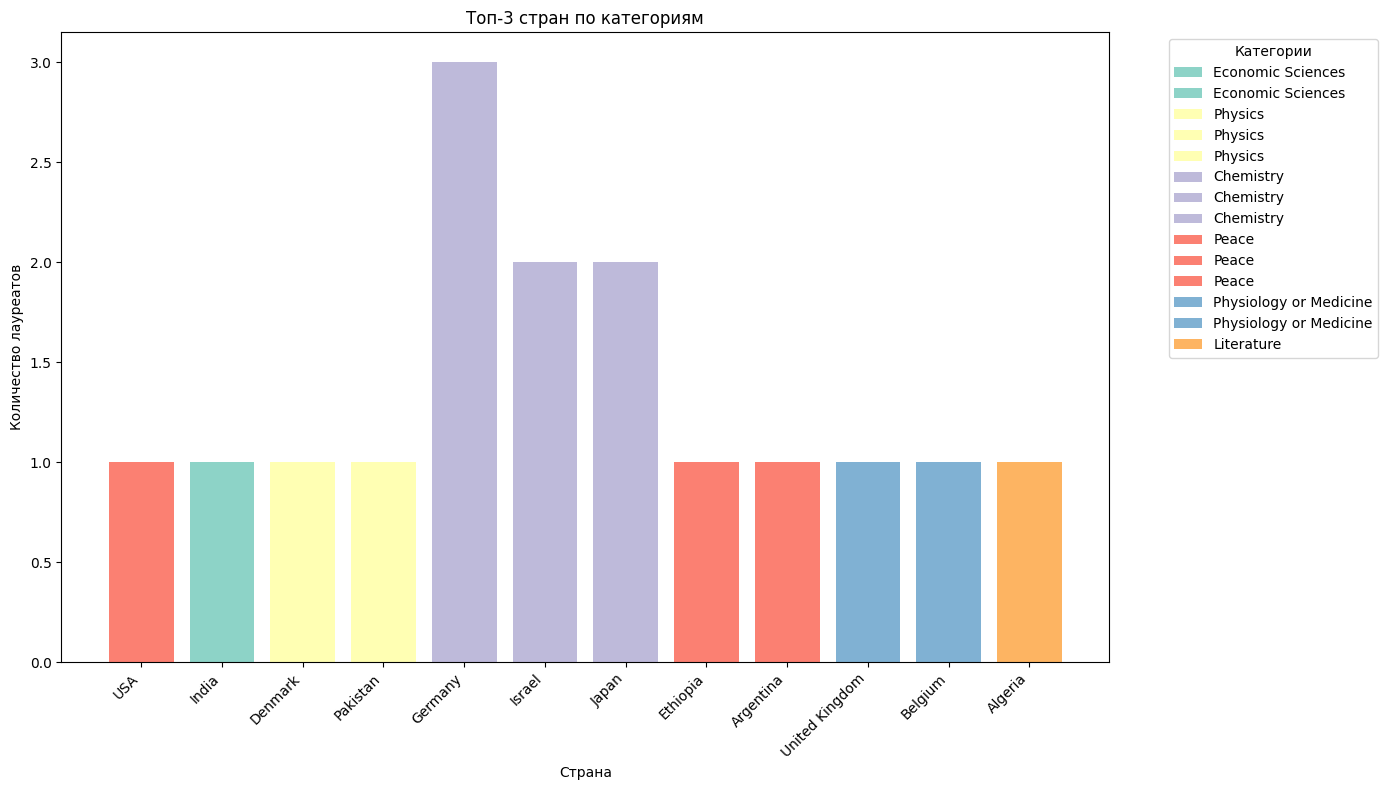

In [35]:
data_with_migration = add_migration_field(laureates_data)

all_countries = []
for item in data_with_migration:
    country = item.get('country_now') or item.get('country_of_origin_adjusted')
    if country:
        all_countries.append(country)

country_counts = Counter(all_countries)
top_countries = country_counts.most_common(5)

if top_countries:
    countries, counts = zip(*top_countries)
    plt.figure(figsize=(10, 6))
    plt.bar(countries, counts)
    plt.title('Топ-5 стран по общему количеству лауреатов')
    plt.xlabel('Страна')
    plt.ylabel('Количество лауреатов')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

fig, ax = plt.subplots(figsize=(14, 8))

all_categories = []
all_countries_plot = []
all_counts_plot = []
colors = plt.cm.Set3(range(len(category_country_data)))

bottom = [0] * len(set(c for countries in category_country_data.values() for c in Counter(countries).most_common(3)[0] if Counter(countries).most_common(3)))

current_bottom = {}
for idx, (category, countries) in enumerate(category_country_data.items()):
    cat_country_counts = Counter(countries)
    top_3 = cat_country_counts.most_common(3)
    
    for country, count in top_3:
        all_categories.append(category)
        all_countries_plot.append(country)
        all_counts_plot.append(count)
        ax.bar(country, count, label=category, bottom=0, color=colors[idx])

ax.set_title('Топ-3 стран по категориям')
ax.set_xlabel('Страна')
ax.set_ylabel('Количество лауреатов')
ax.legend(title='Категории', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()